In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

In [2]:
input_location = 'KTH-alloc-only'
files_prefix = ''
schedule_names = ['filler', 'backfill-1', 'backfill-sjf-1', 'maxutil-10-1', 'maxutil-15-1', 'maxutil-20-1', 'maxutil-comp-5-5-1', 'plan-1']

In [3]:
schedule_files = []
jobs_files = []
for file in os.listdir('../output/' + input_location):
    if file.endswith('_schedule.csv'):
        schedule_files.append(file)
    elif file.endswith('_jobs.csv'):
        jobs_files.append(file)

schedule_files = [os.path.join('../output', input_location, str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', input_location, str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/KTH-alloc-only/backfill-1_schedule.csv', '../output/KTH-alloc-only/backfill-sjf-1_schedule.csv', '../output/KTH-alloc-only/balance-largest-1_schedule.csv', '../output/KTH-alloc-only/balance-ratio-1_schedule.csv', '../output/KTH-alloc-only/balance-smallest-1_schedule.csv', '../output/KTH-alloc-only/fcfs_schedule.csv', '../output/KTH-alloc-only/filler_schedule.csv', '../output/KTH-alloc-only/maxutil-10-1_schedule.csv', '../output/KTH-alloc-only/maxutil-15-1_schedule.csv', '../output/KTH-alloc-only/maxutil-1_schedule.csv', '../output/KTH-alloc-only/maxutil-20-1_schedule.csv', '../output/KTH-alloc-only/maxutil-comp-2-2-1_schedule.csv', '../output/KTH-alloc-only/maxutil-comp-5-5-1_schedule.csv', '../output/KTH-alloc-only/maxutil-ext-1_schedule.csv', '../output/KTH-alloc-only/no-reserve-1_schedule.csv', '../output/KTH-alloc-only/plan-1_schedule.csv']
['../output/KTH-alloc-only/backfill-1_jobs.csv', '../output/KTH-alloc-only/backfill-sjf-1_jobs.csv', '../output/KTH-alloc-only/bala

In [4]:
metrics = pd.DataFrame()
for file in schedule_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

 backfill-1
 backfill-sjf-1
 filler
 maxutil-10-1
 maxutil-15-1
 maxutil-20-1
 maxutil-comp-5-5-1
 plan-1


In [5]:
jobsets = {}
for file in jobs_files:
    if files_prefix:
        workload_name, schedule_name, _ = os.path.basename(file).split('_')
    else:
        workload_name = ''
        schedule_name, _ = os.path.basename(file).split('_')
    if workload_name != files_prefix:
        continue
    if schedule_name in schedule_names:
        print(workload_name, schedule_name)
        jobsets[schedule_name] = JobSet.from_csv(file)

 backfill-1
 backfill-sjf-1
 filler
 maxutil-10-1
 maxutil-15-1
 maxutil-20-1
 maxutil-comp-5-5-1
 plan-1


In [6]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [7]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch', 'bounded_slowdown']]
        dfs.append(df)
    return pd.concat(dfs, axis=0)

In [8]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [9]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
sns.set_theme(context='talk', style='whitegrid')
# sns.set_theme(style='whitegrid')

In [10]:
metrics.T

,filler,backfill-1,backfill-sjf-1,maxutil-10-1,maxutil-15-1,maxutil-20-1,maxutil-comp-5-5-1,plan-1
batsim_version,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0,4.0.0
consumed_joules,0,0,0,0,0,0,0,0
makespan,2.88366e+07,2.87804e+07,2.87889e+07,2.87998e+07,2.87755e+07,2.87856e+07,2.87889e+07,2.87676e+07
max_slowdown,165776,202891,271889,97267,244403,211720,271889,298829
max_turnaround_time,4.73398e+06,645295,865605,690458,691318,832730,865605,823534
max_waiting_time,4.7199e+06,581791,701599,627287,669196,659412,701599,608134
mean_slowdown,241.819,276.146,235.367,218.065,215.162,222.609,235.367,283.289
mean_turnaround_time,29072.5,23782.2,24067.1,23010.7,22796.7,22555.3,24067.1,25330.5
mean_waiting_time,20219.3,14929,15213.9,14157.5,13943.5,13702.1,15213.9,16477.2
nb_computing_machines,109,109,109,109,109,109,109,109


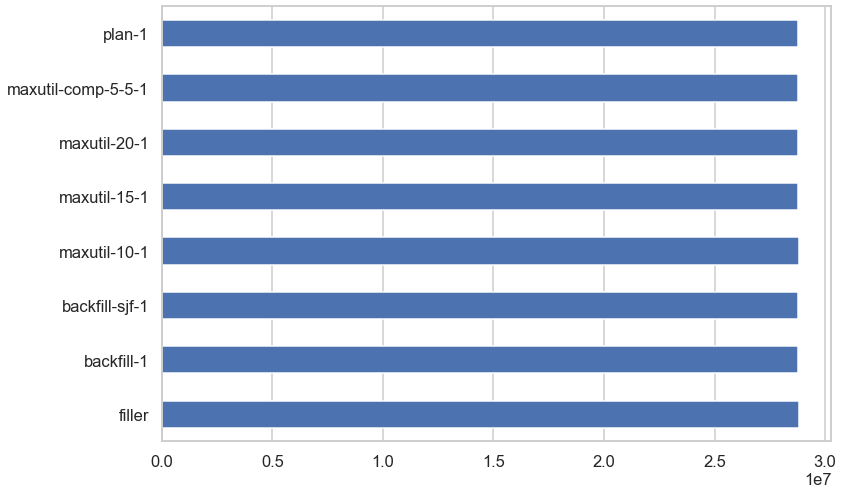

In [11]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

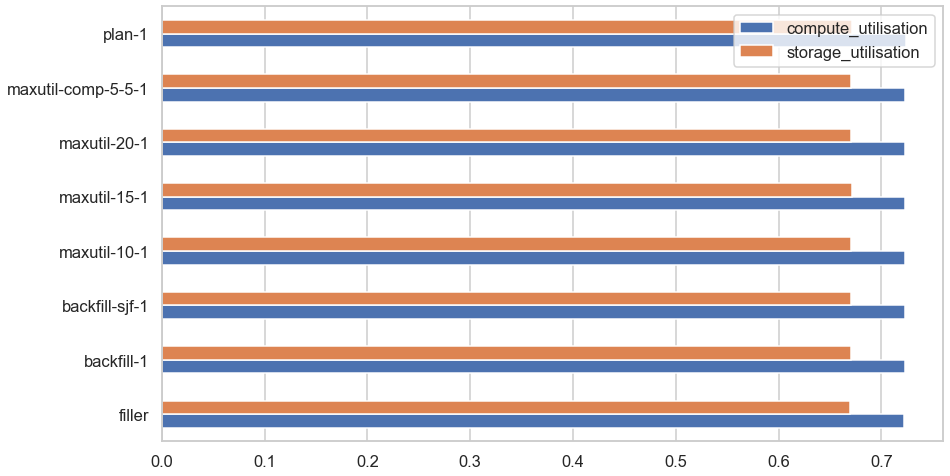

In [12]:
ax = metrics[['compute_utilisation', 'storage_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [13]:
metrics_df = create_all_metrics_df()

In [14]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-10-1,maxutil-15-1,maxutil-20-1,maxutil-comp-5-5-1,plan-1
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,2.022923e+04,14936.336898,15221.368447,14164.477391,13950.324979,13708.829473,15221.368447,16485.356658
std,1.363842e+05,40351.526606,48766.072374,43507.152410,43784.381881,43385.819806,48766.072374,48769.816655
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,74.000300,0.000000,32.000100,2.000300,0.000000,0.000000,116.001350
75%,4.556002e+03,10499.073028,6864.000550,8183.482224,7514.197405,7010.006950,6864.000550,8671.230791
max,4.719901e+06,581791.016150,701599.000850,627287.009650,669196.001200,659412.089775,701599.000850,608133.958544


(0.0, 1000000.0)

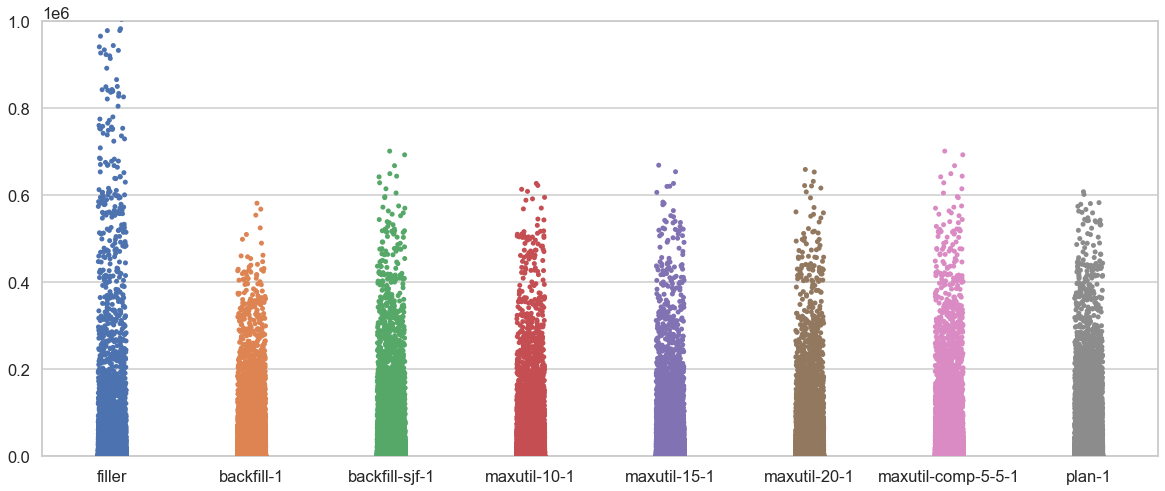

In [15]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=waiting_times, ax=ax)
ax.set_ylim(0, 10**6)

<AxesSubplot:>

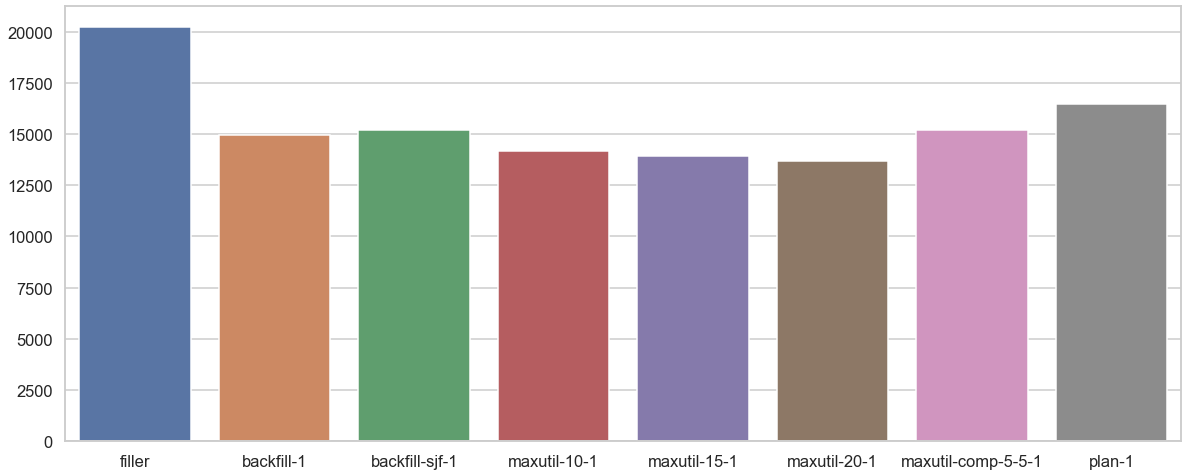

In [16]:
# Mean
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, ci=None, ax=ax)

<AxesSubplot:>

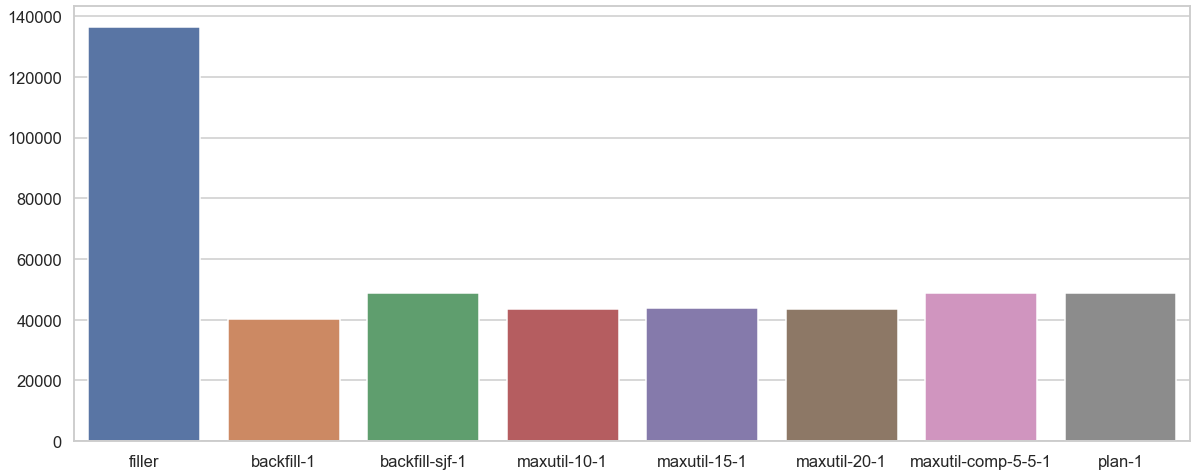

In [17]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=waiting_times, estimator=np.std, ci=None, ax=ax)

(0.0, 27541.7946636)

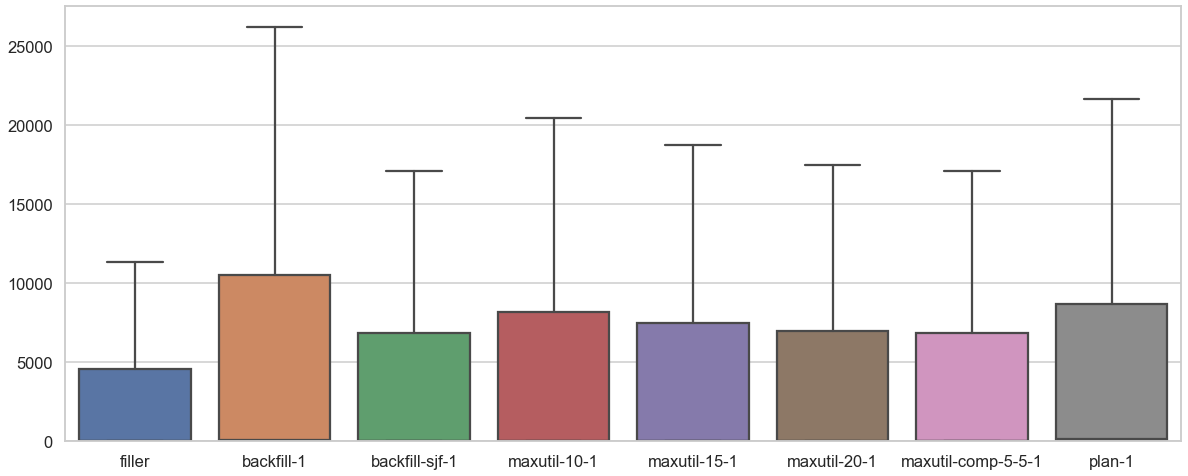

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=waiting_times, showfliers=False, ax=ax)
ax.set_ylim(0)

(0.0, 72129.2184330375)

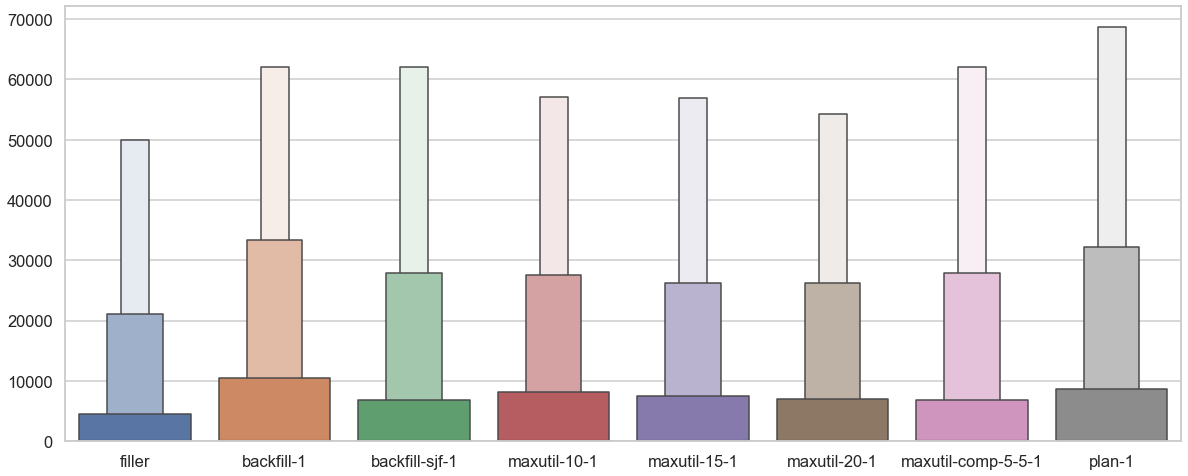

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
sns.boxenplot(data=waiting_times, showfliers=False, k_depth=3, ax=ax)
ax.set_ylim(0)

In [20]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-10-1,maxutil-15-1,maxutil-20-1,maxutil-comp-5-5-1,plan-1
count,2.845300e+04,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,2.908680e+04,23793.916896,24078.943951,23022.049390,22807.895872,22566.400890,24078.943951,25342.936319
std,1.379345e+05,47628.384835,55765.402612,50322.473266,50527.275329,50218.117601,55765.402612,56593.505448
min,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.290003e+02,300.000000,234.000300,251.000200,239.000000,237.000300,234.000300,197.005700
50%,5.095001e+03,6383.000000,4868.000150,5788.000000,5356.002150,5345.000300,4868.000150,5136.002150
75%,2.009200e+04,26174.865404,21427.001250,23017.002150,22392.005150,21758.950778,21427.001250,23344.004950
max,4.733983e+06,645295.004500,865605.012550,690457.869417,691317.875367,832729.958892,865605.012550,823533.958544


(0.0, 1000000.0)

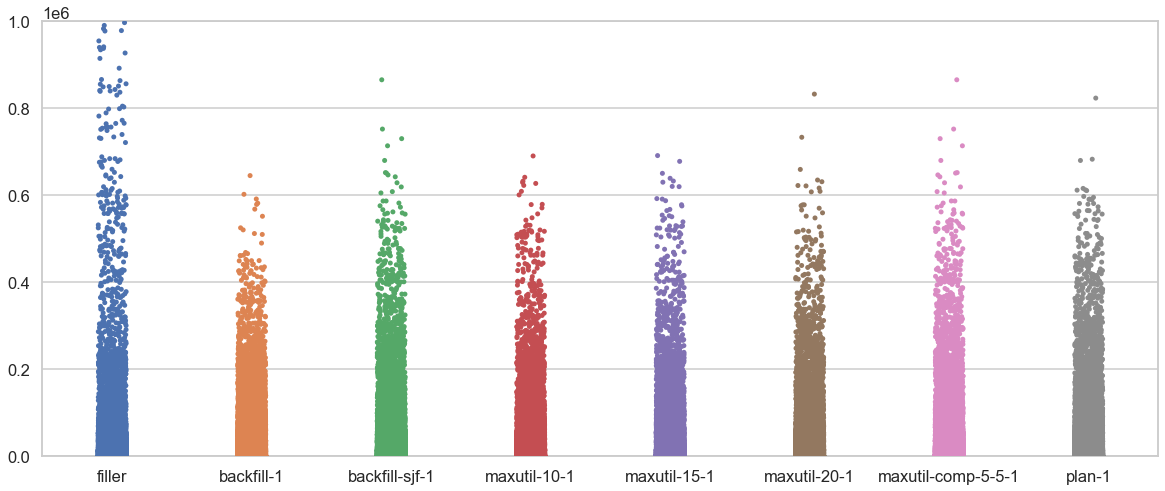

In [21]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=turnaround_times, ax=ax)
ax.set_ylim(0,10**6)

<AxesSubplot:>

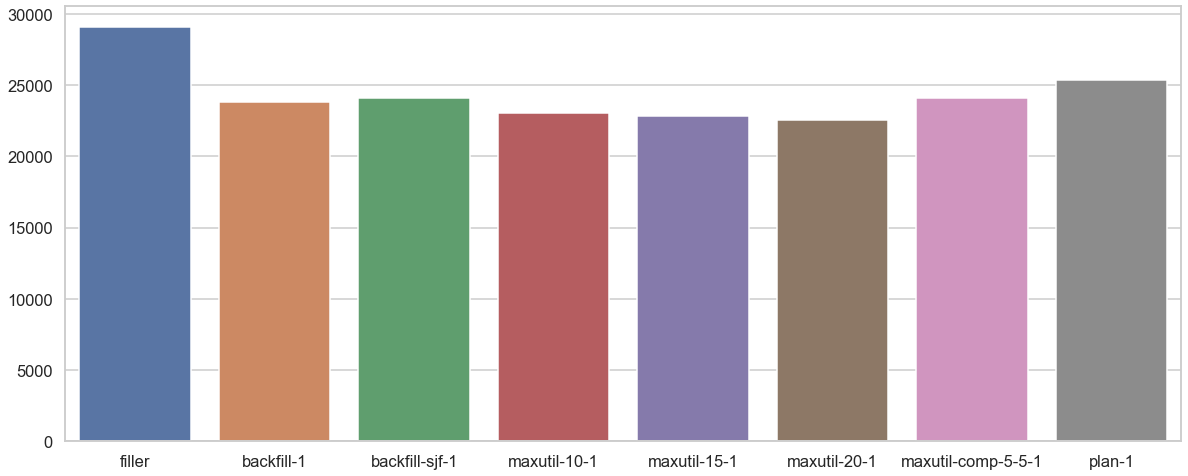

In [22]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, ci=None, ax=ax)

<AxesSubplot:>

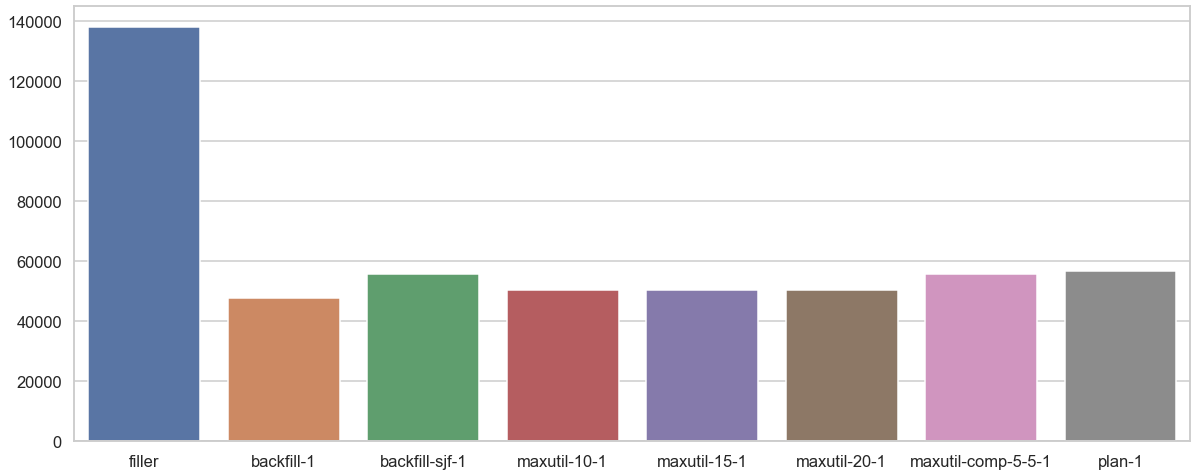

In [23]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=turnaround_times, estimator=np.std, ci=None, ax=ax)

(0.0, 68201.65567000001)

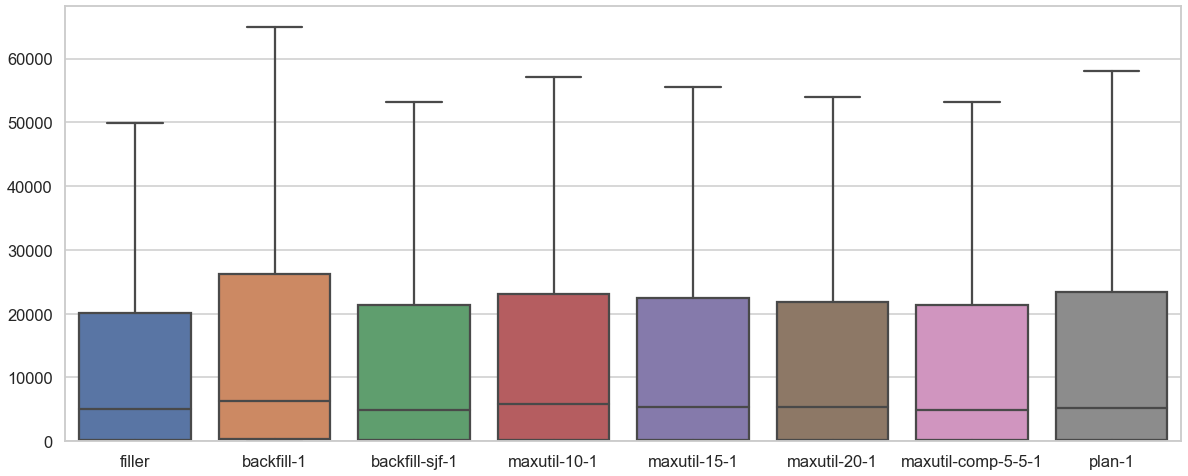

In [24]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=turnaround_times, showfliers=False, ax=ax)
ax.set_ylim(0)

In [25]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,filler,backfill-1,backfill-sjf-1,maxutil-10-1,maxutil-15-1,maxutil-20-1,maxutil-comp-5-5-1,plan-1
count,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000,28453.000000
mean,241.937698,276.281974,235.482689,218.172279,215.267947,222.718303,235.482689,283.428815
std,2253.940419,2524.991508,2972.423192,2033.869565,2457.108501,2569.322168,2972.423192,3891.807174
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.034806,1.000000,1.016614,1.000559,1.000000,1.000000,1.056968
75%,4.377905,6.958020,4.907561,5.762330,4.953943,4.955879,4.907561,4.918837
max,165776.052878,202891.080026,271889.422325,97267.043320,244402.846610,211719.694878,271889.422325,298829.236254


(0.0, 200000.0)

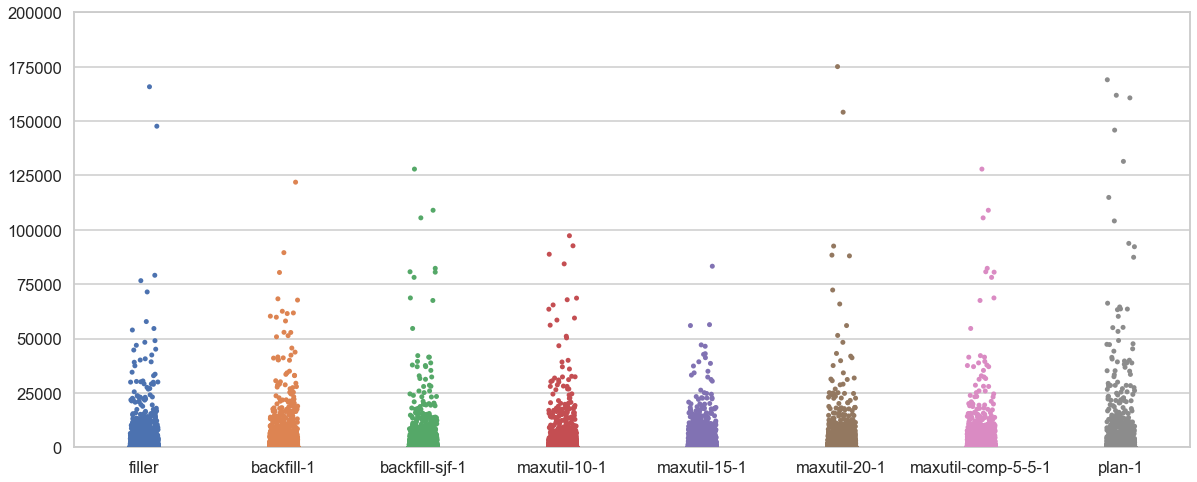

In [26]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=slowdown, ax=ax)
ax.set_ylim(0, 0.2*10**6)

<AxesSubplot:>

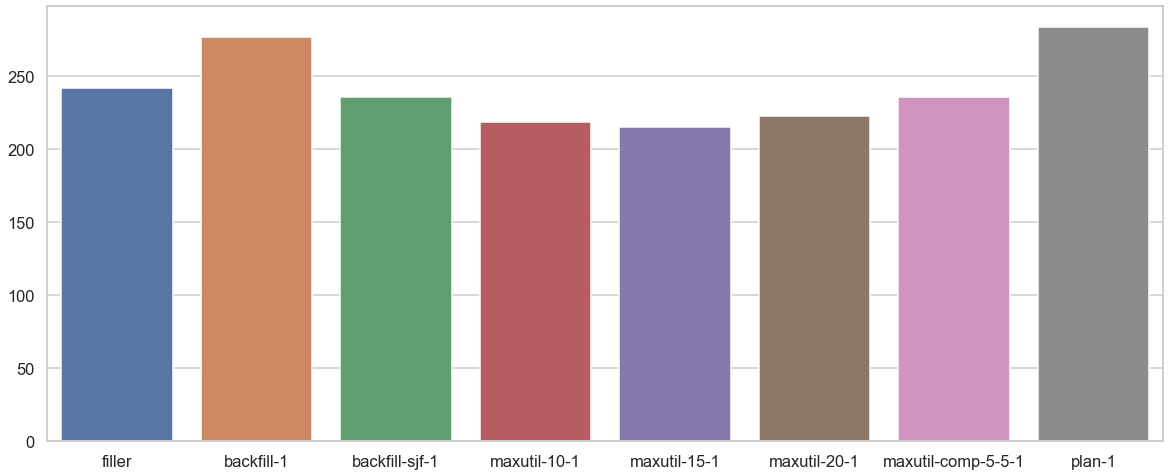

In [27]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, ci=None, ax=ax)

<AxesSubplot:>

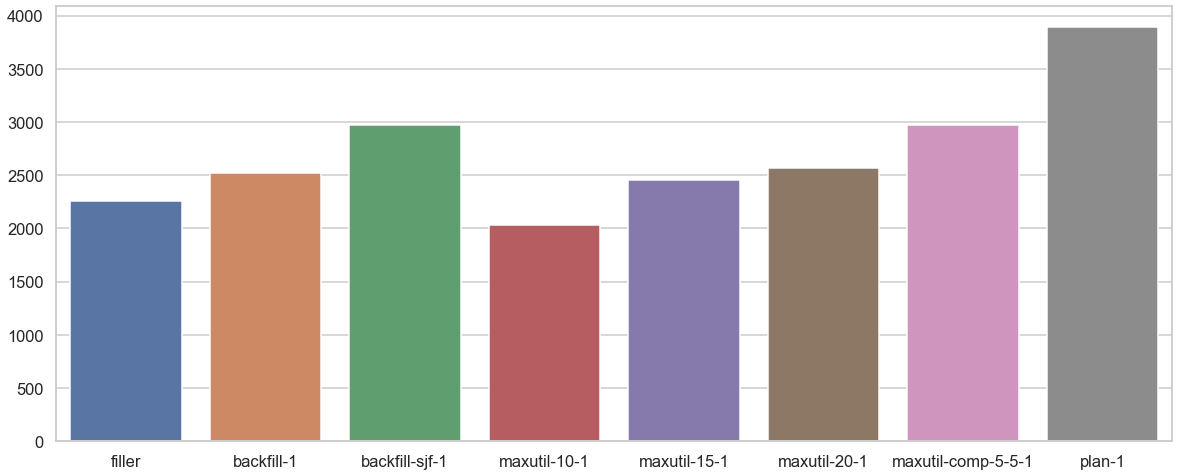

In [28]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=slowdown, estimator=np.std, ci=None, ax=ax)

(1.0, 16.623538)

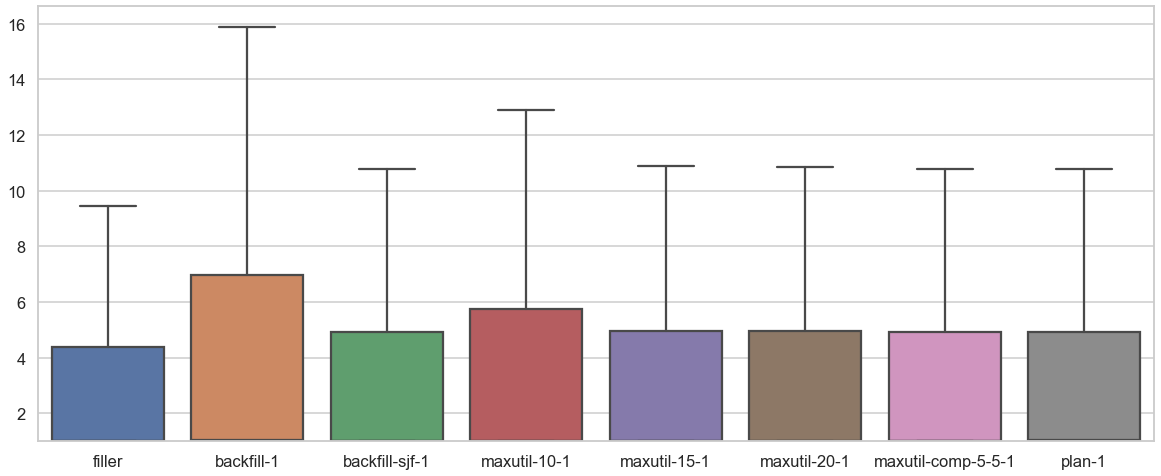

In [29]:
fig, ax = plt.subplots(figsize=(20,8))
sns.boxplot(data=slowdown, showfliers=False, ax=ax)
ax.set_ylim(1)

(0.0, 50678.47539122816)

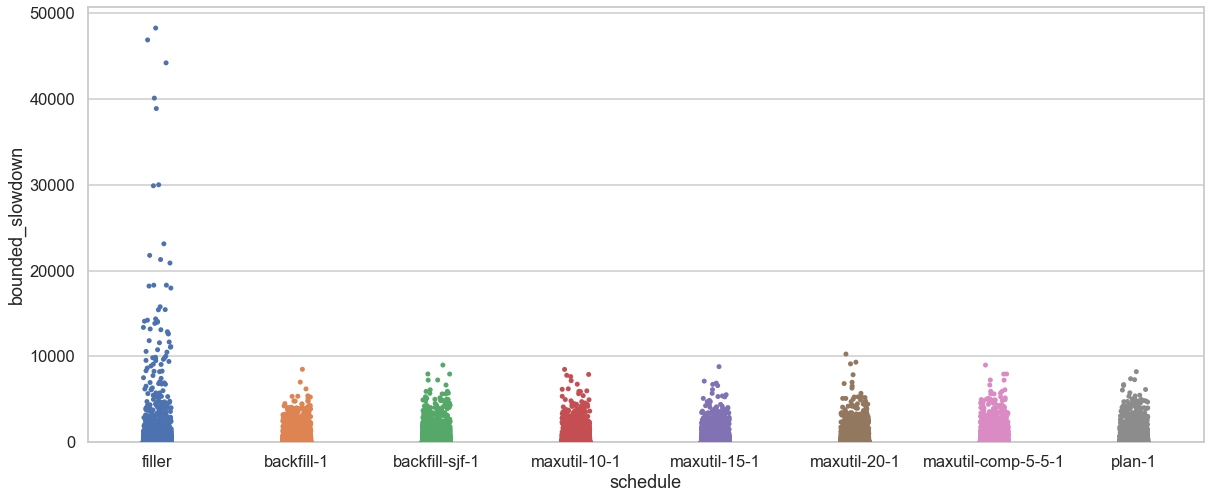

In [30]:
# Scatterplot, outliers
fig, ax = plt.subplots(figsize=(20,8))
sns.stripplot(data=metrics_df, x='schedule', y='bounded_slowdown', ax=ax)
ax.set_ylim(0)

<AxesSubplot:xlabel='schedule', ylabel='bounded_slowdown'>

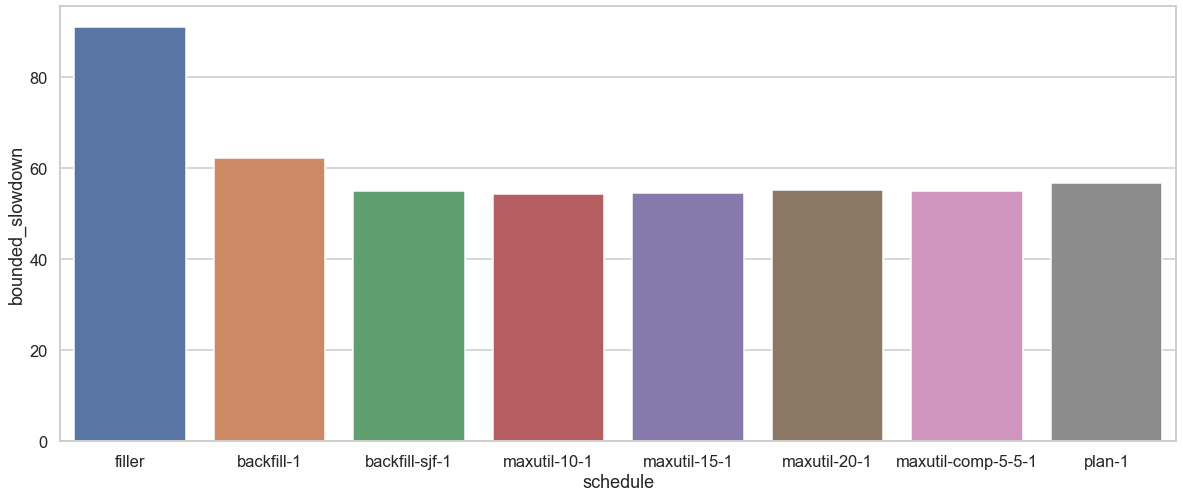

In [31]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', ci=None, ax=ax)

<AxesSubplot:xlabel='schedule', ylabel='bounded_slowdown'>

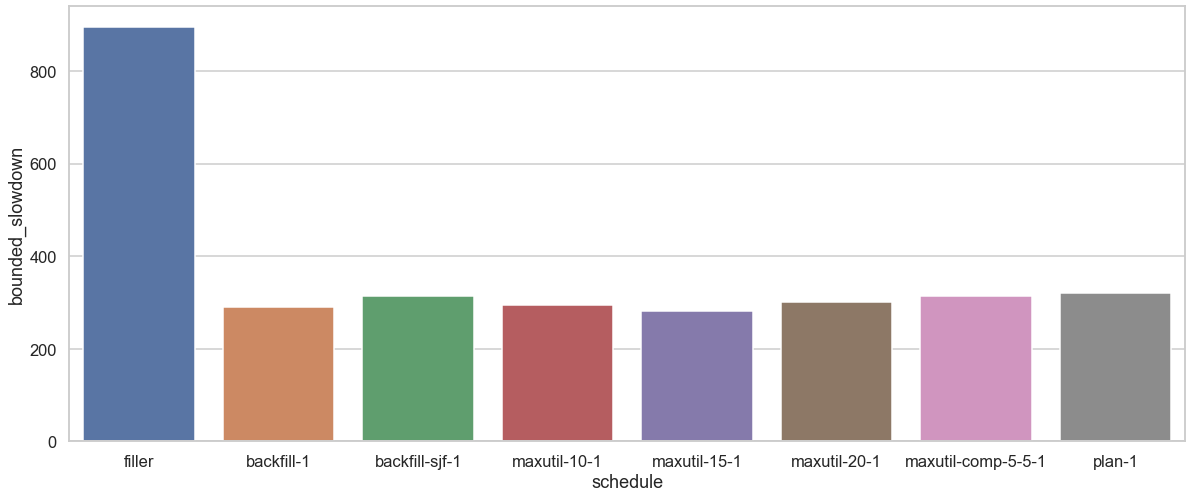

In [32]:
# Standard deviation
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(data=metrics_df, x='schedule', y='bounded_slowdown', estimator=np.std, ci=None, ax=ax)

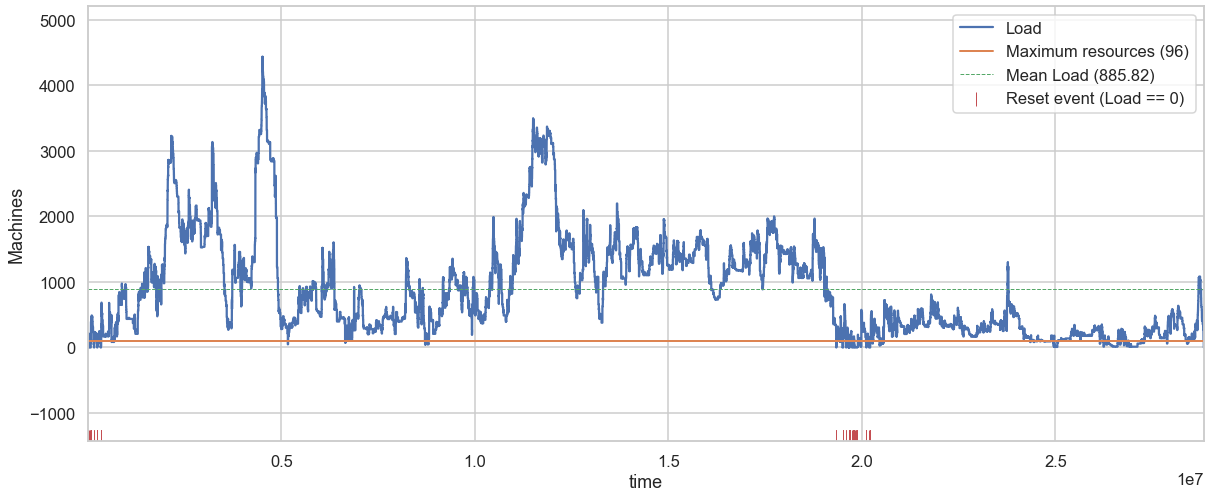

In [382]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['filler'].queue, nb_resources=96, ax=ax)

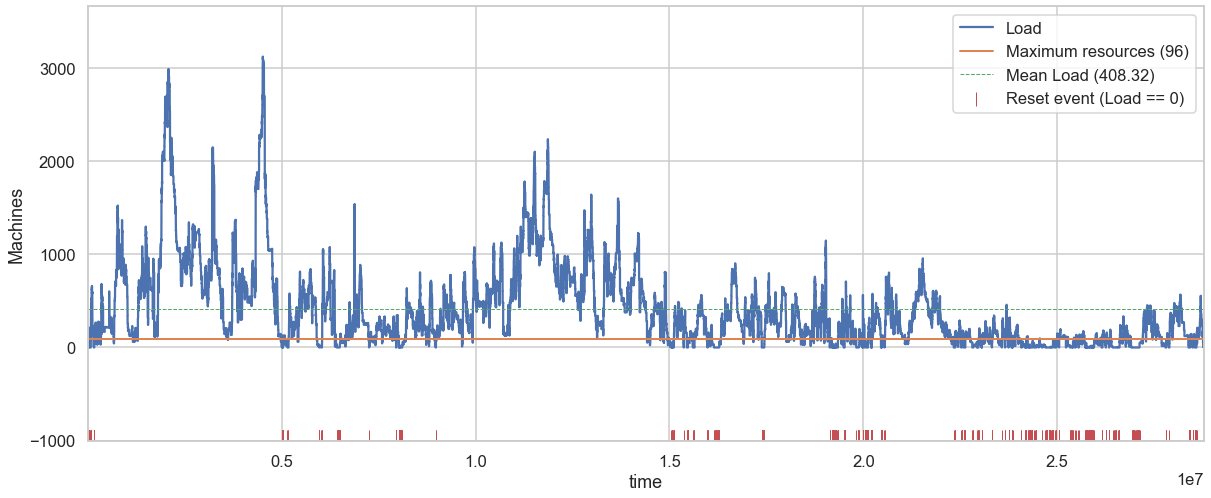

In [383]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['backfill-1'].queue, nb_resources=96, ax=ax)

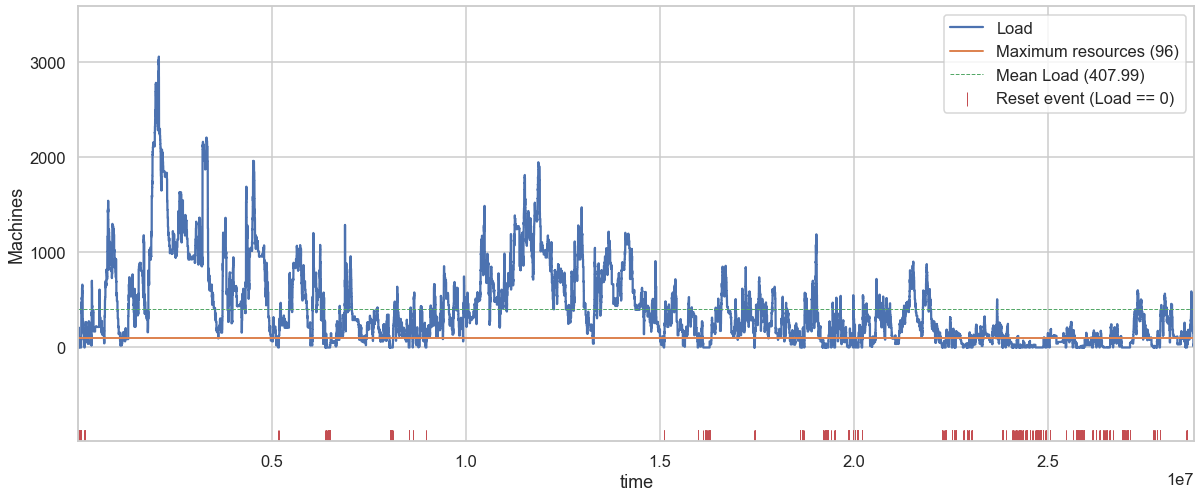

In [384]:
fig, ax = plt.subplots(figsize=(20,8))
visu.legacy.plot_load(jobsets['maxutil-1'].queue, nb_resources=96, ax=ax)

In [282]:
def storage_queue(js):
    df = js.df.assign(total_storage=js.df.metadata * js.df.requested_number_of_resources)
    return evalys.metrics.compute_load(df, 'submission_time', 'starting_time', 'total_storage')

def storage_utilisation(js):
    df = js.df.assign(total_storage=js.df.metadata * js.df.requested_number_of_resources)
    return evalys.metrics.compute_load(df, 'starting_time', 'finish_time', 'total_storage')

def remove_immidiate_timepoints(load):
    return load[load.assign(time_diff=df.index).diff().shift(-1)['time_diff'] >= 1]

In [411]:
js = jobsets['maxutil-20-1']

In [412]:
js.utilisation

,load,area
time,,
1.000000e+00,4,688.0000
1.730000e+02,29,13166.0000
6.270000e+02,34,69156.0068
2.661000e+03,9,0.0009
2.661000e+03,26,21241.9961
...,...,...
2.876378e+07,12,187728.0648
2.877942e+07,4,0.0004
2.877942e+07,16,736.0032


In [413]:
js.queue

,load,area
time,,
1.000000e+00,0,0.0000
1.730000e+02,0,0.0000
6.270000e+02,0,0.0000
9.870000e+02,17,28458.0051
2.661000e+03,0,0.0000
...,...,...
2.875892e+07,12,37464.0000
2.876204e+07,12,17976.0000
2.876354e+07,12,2808.0000


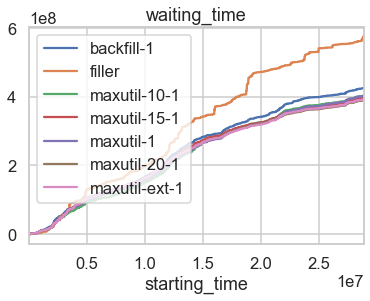

In [415]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/evalys/visu/core.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


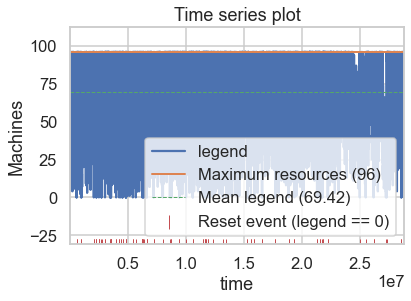

In [70]:
visu.series.plot_series(js, name='utilization', legend_label='legend')

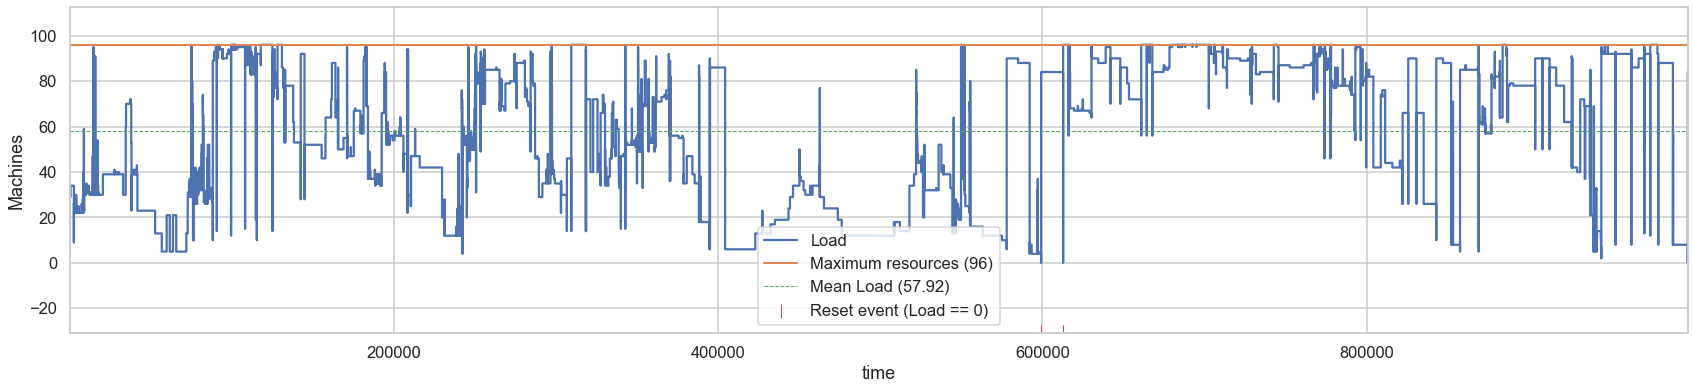

In [428]:
fig, ax = plt.subplots(figsize=(29,6))
df = js.utilisation
df = df[df.index < 0.1 * 1e7]
# df = remove_immidiate_timepoints(df)
evalys.visu.legacy.plot_load(df, 96)

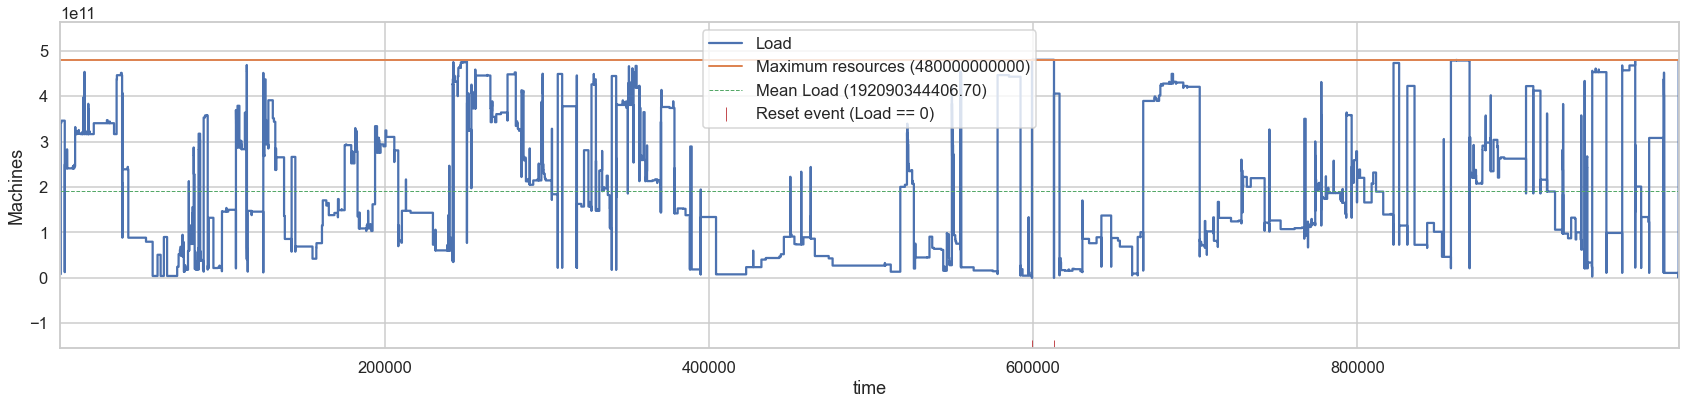

In [417]:
fig, ax = plt.subplots(figsize=(29,6))
df = storage_utilisation(js)
df = df[df.index < 0.1 * 1e7]
evalys.visu.legacy.plot_load(df, 480000000000)

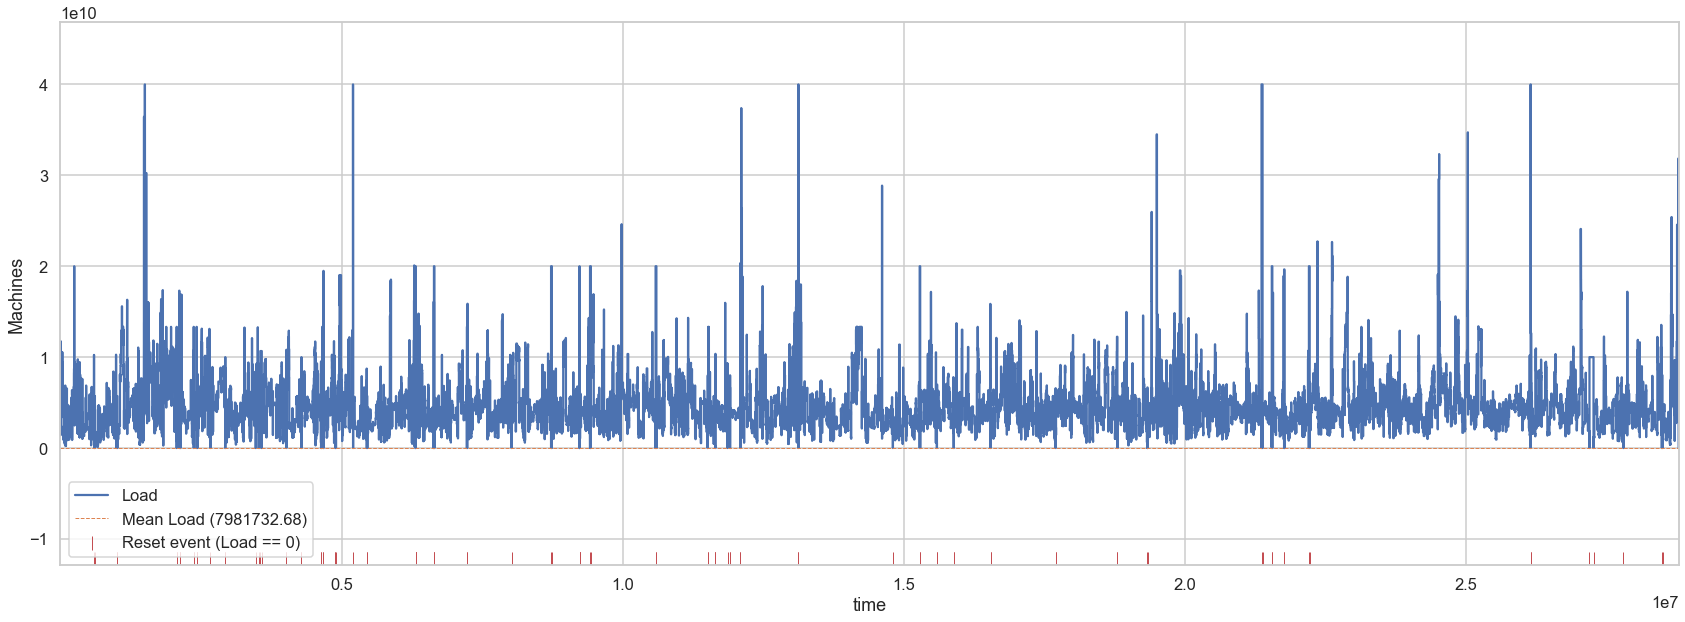

In [420]:
df = storage_utilisation(js) / js.utilisation
df = df.fillna(0)
# df = remove_immidiate_timepoints(df)
# df = df[df.index < 0.5 * 1e7]
fig, ax = plt.subplots(figsize=(29,10))
evalys.visu.legacy.plot_load(df)

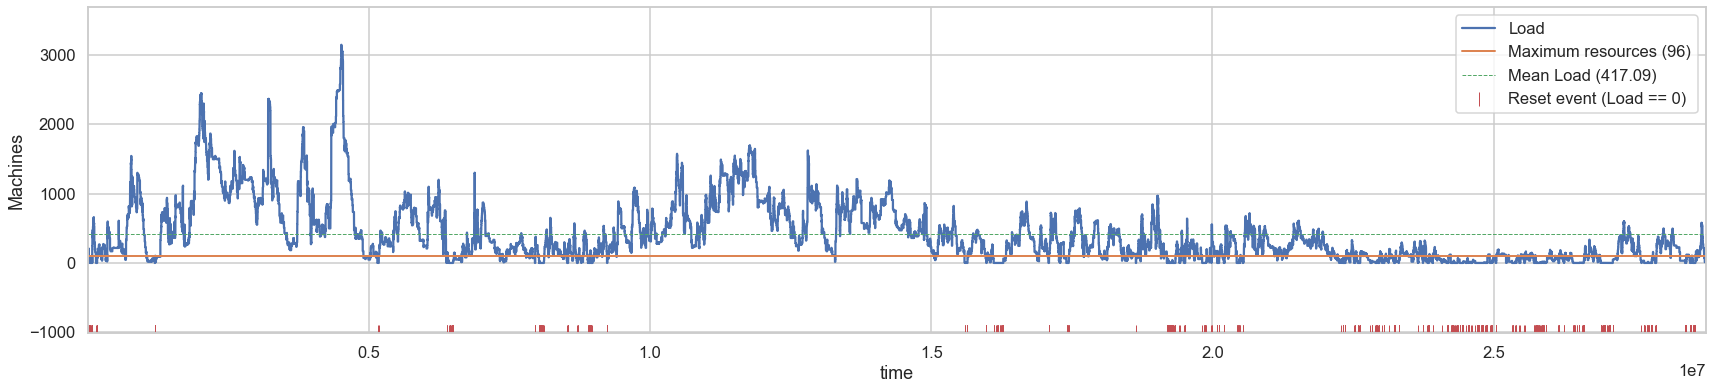

In [421]:
fig, ax = plt.subplots(figsize=(29,6))
df = js.queue
evalys.visu.legacy.plot_load(df, 96)

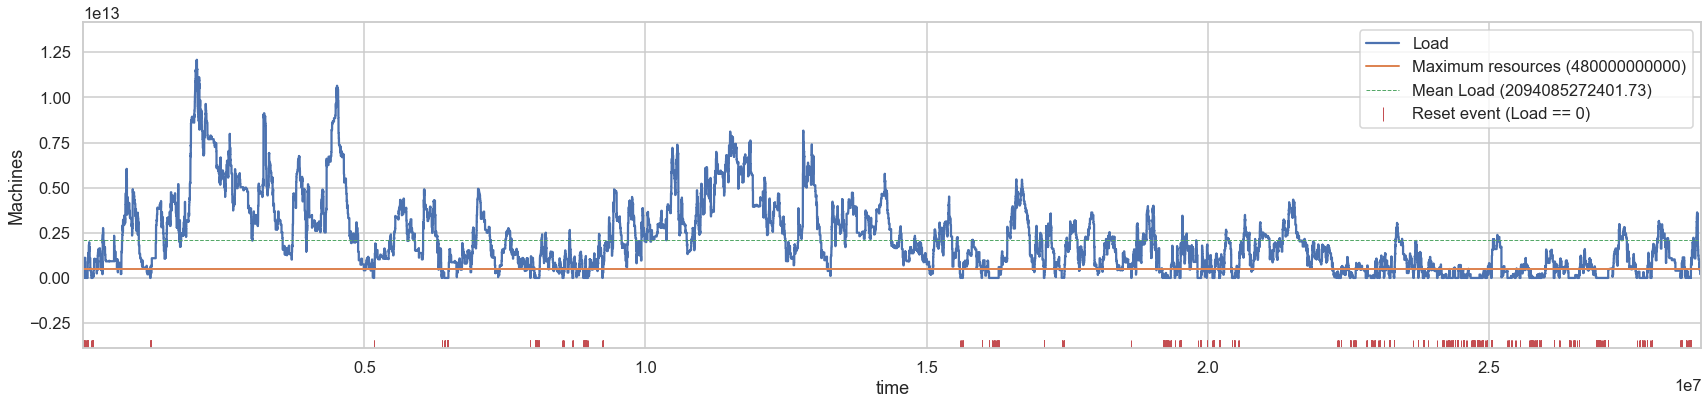

In [422]:
fig, ax = plt.subplots(figsize=(29,6))
df = storage_queue(js)
evalys.visu.legacy.plot_load(df, 480000000000)

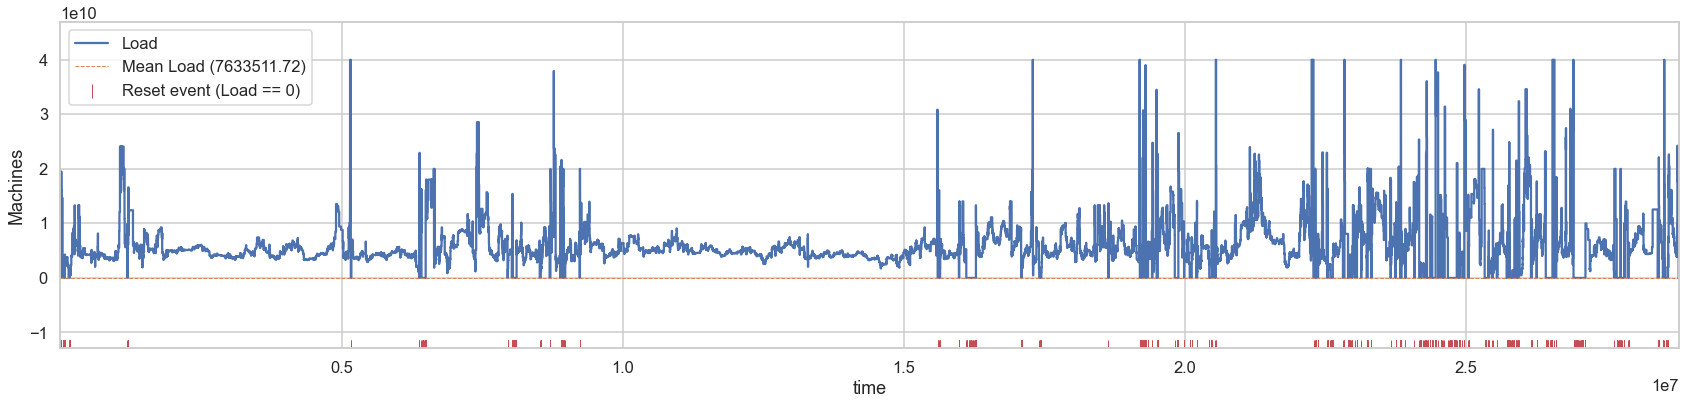

In [429]:
df = storage_queue(js) / js.queue
df = df.fillna(0)
# df = df[df.index < 0.1 * 1e7]
fig, ax = plt.subplots(figsize=(29,6))
evalys.visu.legacy.plot_load(df)

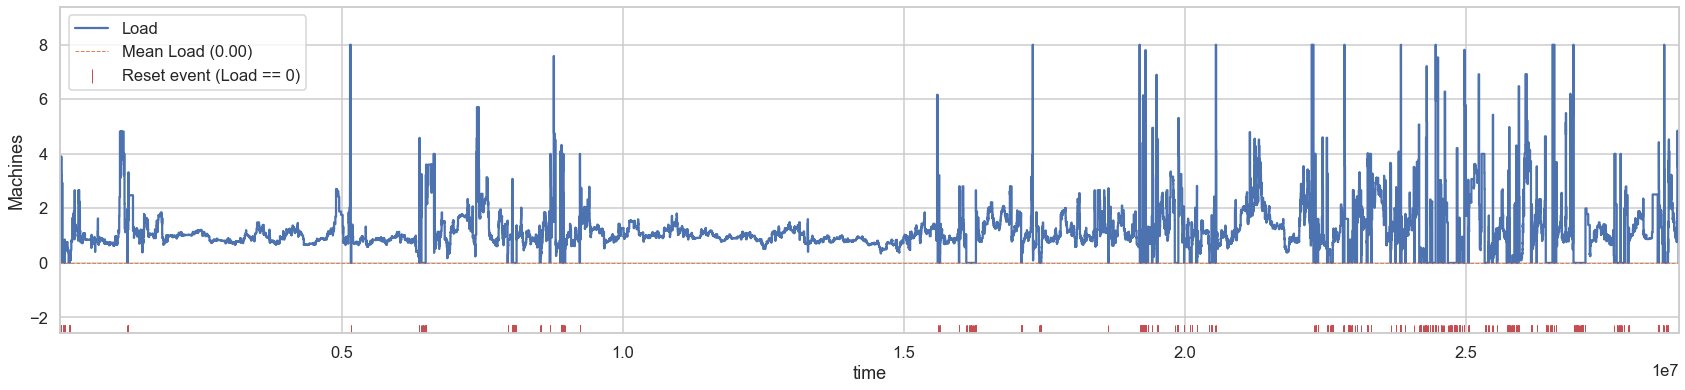

In [424]:
df = df = (storage_queue(js) / 480000000000) / (js.queue / 96)  # Queue ratio
df = df.fillna(0)
# df = df[df.index < 0.1 * 1e7]
fig, ax = plt.subplots(figsize=(29,6))
evalys.visu.legacy.plot_load(df)

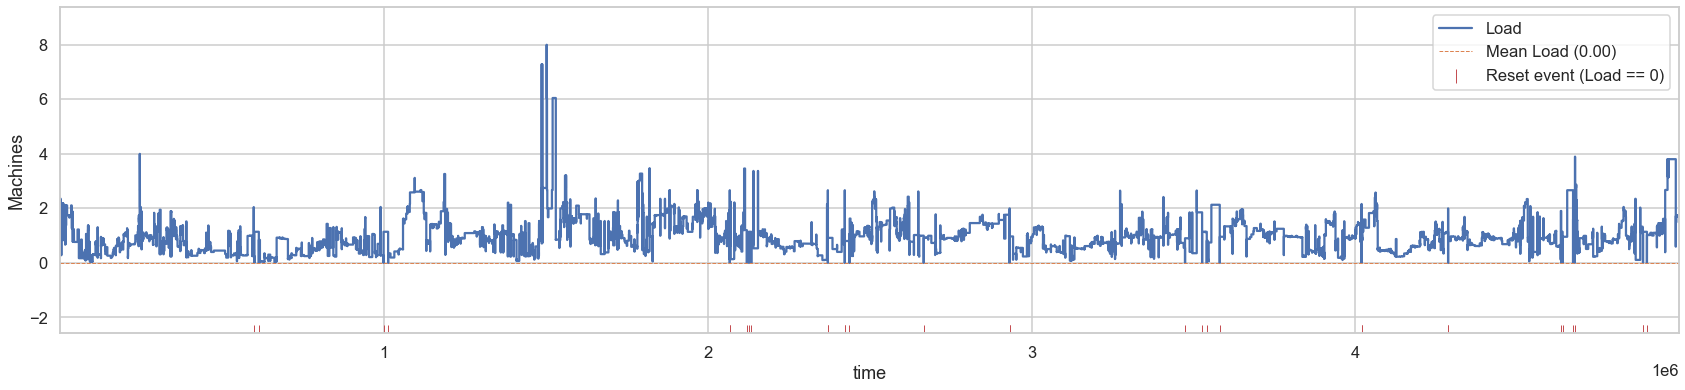

In [425]:
# When point is at 1.0 then storage and compute utilisation is balanced. Below 1.0 compute dominates.
df = (storage_utilisation(js) / 480000000000) / (js.utilisation / 96)  # Utilisation ratio
df = df.fillna(0)
df = df[df.index < 0.5 * 1e7]
fig, ax = plt.subplots(figsize=(29,6))
evalys.visu.legacy.plot_load(df)